In [1]:
from src.helpers.experiment import create_tsfresh_dataframe
from src.helpers.diabetes.cega import clarke_error_grid
from src.helpers.diabetes.madex import mean_adjusted_exponent_error
from pycaret.regression import setup, create_model, compare_models, predict_model
from loguru import logger
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas

In [2]:
train_parameters = {
    'ohio_no': 588,
    'scope': 'train',
    'train_ds_size': 0,
    'window_size': 6,
    'prediction_horizon': 1,
    'minimal_features': False,
}

unseen_data_parameters = {
    'ohio_no': 588,
    'scope': 'test',
    'train_ds_size': 0,
    'window_size': 6,
    'prediction_horizon': 1,
    'minimal_features': False,
}

# output = run_experiment(parameters, test_parameters)

2021-06-26 09:09:45.653 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/588_train_0_6_1.pkl
2021-06-26 09:09:45.808 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 588, 'scope': 'train', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 1, 'minimal_features': False}


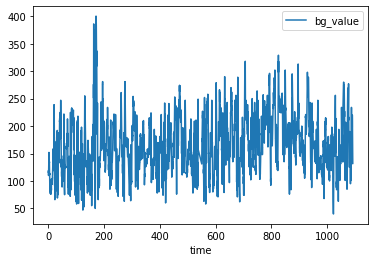

2021-06-26 09:09:46.160 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-06-26 09:09:46.161 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/588_train_0_6_1.pkl


In [3]:
source_df = create_tsfresh_dataframe(train_parameters)
clean_df = source_df.drop(
    columns=['start', 'end', 'start_time', 'end_time'])

In [4]:
regressor = setup(clean_df,
    target='label',
    feature_selection=True,
    html=True,
    silent=True,
    session_id=1974
    )

,Description,Value
0,session_id,1974
1,Target,label
2,Original Data,"(12634, 788)"
3,Missing Values,True
4,Numeric Features,260
5,Categorical Features,527
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(8843, 236)"


In [5]:
best3 = compare_models(
    exclude=['catboost', 'xgboost'],
    sort='RMSE',
    n_select=3,
    verbose=True
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,3.2728,29.3283,5.4117,0.9886,0.0358,0.0217,0.2220
br,Bayesian Ridge,3.2461,30.5485,5.5141,0.9881,0.0373,0.0214,0.1160
lasso,Lasso Regression,3.3133,31.0301,5.5483,0.9880,0.0363,0.0220,0.2180
omp,Orthogonal Matching Pursuit,3.3261,31.3531,5.5906,0.9878,0.0367,0.0220,0.0370
ridge,Ridge Regression,3.2847,32.3370,5.6667,0.9874,0.0375,0.0216,0.0480
gbr,Gradient Boosting Regressor,3.7380,33.4455,5.7782,0.9870,0.0390,0.0248,4.2080
et,Extra Trees Regressor,3.6791,34.3295,5.8496,0.9866,0.0394,0.0244,6.6150
lightgbm,Light Gradient Boosting Machine,3.6433,34.3241,5.8503,0.9867,0.0391,0.0241,0.5360
rf,Random Forest Regressor,3.7334,37.1234,6.0786,0.9856,0.0406,0.0248,10.6310
dt,Decision Tree Regressor,5.6903,74.1583,8.6041,0.9712,0.0584,0.0375,0.2400


In [6]:
best3

[ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=1974, selection='cyclic', tol=0.0001, warm_start=False),
 BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
               compute_score=False, copy_X=True, fit_intercept=True,
               lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
               normalize=False, tol=0.001, verbose=False),
 Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=1974,
       selection='cyclic', tol=0.0001, warm_start=False)]

In [7]:
master_output = {}

In [8]:
def run_model(model_to_run):
    output = {}
    model = create_model(model_to_run)
    model_name = model.__str__().split('(')[0]
    logger.info(f'Processing model: {model_name}')
    output['model'] = model
    output['model_name'] = model_name
    pd = predict_model(model)
    (_, res) = clarke_error_grid(pd['label'], pd['Label'], 'Test')
    output['internal_cga_analysis'] = res
    rmse = np.sqrt(mean_squared_error(pd['label'], pd['Label']))
    rmadex = np.sqrt(mean_adjusted_exponent_error(
        pd['label'], pd['Label']))
    output['internal_rmse'] = rmse
    output['internal_rmadex'] = rmadex

    unseen_df = create_tsfresh_dataframe(unseen_data_parameters)
    clean_unseen_df = unseen_df.drop(
        columns=['start', 'end', 'start_time', 'end_time'])
    unseen_pd = predict_model(model, data=clean_unseen_df)
    (_, res) = clarke_error_grid(unseen_pd['label'], unseen_pd['Label'], 'Test')
    output['unseen_cga_analysis'] = res
    rmse = np.sqrt(mean_squared_error(unseen_pd['label'], unseen_pd['Label']))
    rmadex = np.sqrt(mean_adjusted_exponent_error(
        unseen_pd['label'], unseen_pd['Label']))
    output['unseen_rmse'] = rmse
    output['unseen_rmadex'] = rmadex
    logger.info(output)
    master_output[model_name] = output
    # df_array.append()
    

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.2632,31.2051,5.5862,0.9884,0.0396,0.0223
1,3.2678,26.6072,5.1582,0.9900,0.0336,0.0217
2,3.1446,26.8465,5.1814,0.9895,0.0360,0.0216
3,3.4321,27.9760,5.2892,0.9892,0.0358,0.0225
4,3.4374,32.5483,5.7051,0.9870,0.0387,0.0231
5,3.2511,33.1774,5.7600,0.9880,0.0366,0.0216
6,3.2289,27.7544,5.2682,0.9887,0.0335,0.0207
7,3.2247,27.8578,5.2780,0.9890,0.0336,0.0210
8,3.1949,30.1418,5.4902,0.9885,0.0357,0.0215
9,3.2834,29.1681,5.4008,0.9878,0.0351,0.0216


2021-06-26 09:14:35.150 | INFO     | __main__:run_model:5 - Processing model: ElasticNet


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.2580,39.6887,6.2999,0.9840,0.0433,0.0219


2021-06-26 09:14:35.478 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/588_test_0_6_1.pkl
2021-06-26 09:14:35.522 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 588, 'scope': 'test', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 1, 'minimal_features': False}


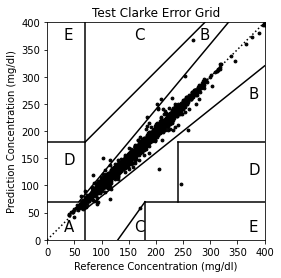

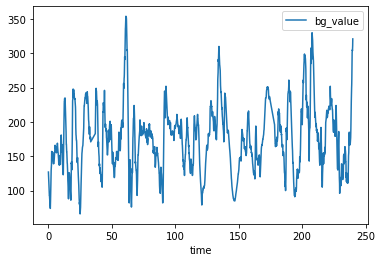

2021-06-26 09:14:35.789 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-06-26 09:14:35.790 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/588_test_0_6_1.pkl
2021-06-26 09:14:36.808 | INFO     | __main__:run_model:28 - {'model': ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=1974, selection='cyclic', tol=0.0001, warm_start=False), 'model_name': 'ElasticNet', 'internal_cga_analysis': [3771, 17, 0, 3, 0], 'internal_rmse': 6.299894, 'internal_rmadex': 76.7682945269202, 'unseen_cga_analysis': [2783, 2, 0, 0, 0], 'unseen_rmse': 4.090810300594865, 'unseen_rmadex': 4.441852151455744}


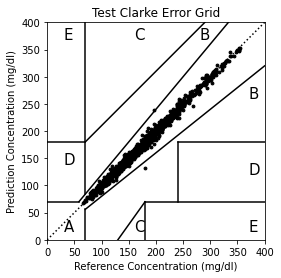

In [9]:
run_model(best3[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.3263,35.3818,5.9483,0.9868,0.0422,0.0224
1,3.2200,27.2968,5.2246,0.9897,0.0334,0.0212
2,3.1582,32.9104,5.7368,0.9871,0.0384,0.0214
3,3.3875,28.1192,5.3028,0.9891,0.0358,0.0221
4,3.4783,40.1224,6.3342,0.9840,0.0524,0.0232
5,3.1099,24.3865,4.9383,0.9912,0.0324,0.0204
6,3.1993,28.5420,5.3425,0.9884,0.0341,0.0205
7,3.1766,28.9784,5.3832,0.9885,0.0335,0.0205
8,3.1580,30.6228,5.5338,0.9884,0.0359,0.0212
9,3.2466,29.1249,5.3967,0.9878,0.0350,0.0212


2021-06-26 09:14:38.649 | INFO     | __main__:run_model:5 - Processing model: BayesianRidge


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.2325,39.9804,6.3230,0.9839,0.0434,0.0215


2021-06-26 09:14:38.950 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/588_test_0_6_1.pkl
2021-06-26 09:14:38.968 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 588, 'scope': 'test', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 1, 'minimal_features': False}


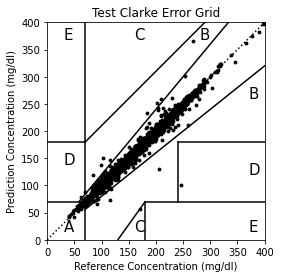

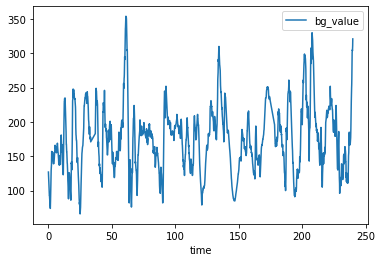

2021-06-26 09:14:39.224 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-06-26 09:14:39.224 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/588_test_0_6_1.pkl
2021-06-26 09:14:40.203 | INFO     | __main__:run_model:28 - {'model': BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False), 'model_name': 'BayesianRidge', 'internal_cga_analysis': [3775, 12, 1, 3, 0], 'internal_rmse': 6.323009391107487, 'internal_rmadex': 83.96785416518641, 'unseen_cga_analysis': [2783, 2, 0, 0, 0], 'unseen_rmse': 4.0555216191938355, 'unseen_rmadex': 4.420274416916832}


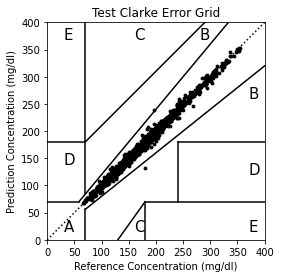

In [10]:
run_model(best3[1])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.2598,30.2278,5.4980,0.9887,0.0395,0.0223
1,3.2951,26.4379,5.1418,0.9900,0.0337,0.0219
2,3.1608,27.8897,5.2811,0.9891,0.0361,0.0217
3,3.4703,28.3344,5.3230,0.9891,0.0360,0.0228
4,3.4729,32.4891,5.6999,0.9870,0.0373,0.0232
5,3.3736,48.5567,6.9683,0.9825,0.0405,0.0225
6,3.2470,27.5770,5.2514,0.9888,0.0335,0.0209
7,3.2816,28.6879,5.3561,0.9886,0.0343,0.0214
8,3.2429,30.4272,5.5161,0.9884,0.0360,0.0218
9,3.3288,29.6734,5.4473,0.9876,0.0355,0.0220


2021-06-26 09:14:42.850 | INFO     | __main__:run_model:5 - Processing model: Lasso


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.2928,39.5627,6.2899,0.9840,0.0435,0.0222


2021-06-26 09:14:43.177 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/588_test_0_6_1.pkl
2021-06-26 09:14:43.196 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 588, 'scope': 'test', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 1, 'minimal_features': False}


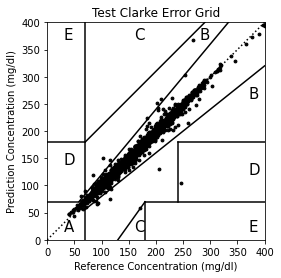

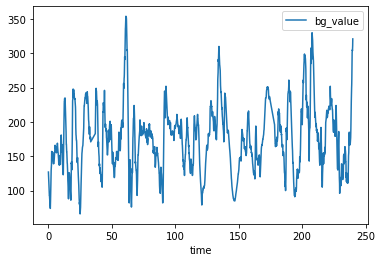

2021-06-26 09:14:43.453 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-06-26 09:14:43.453 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/588_test_0_6_1.pkl
2021-06-26 09:14:44.420 | INFO     | __main__:run_model:28 - {'model': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1974,
      selection='cyclic', tol=0.0001, warm_start=False), 'model_name': 'Lasso', 'internal_cga_analysis': [3773, 15, 0, 3, 0], 'internal_rmse': 6.2898903, 'internal_rmadex': 75.62778424787604, 'unseen_cga_analysis': [2783, 2, 0, 0, 0], 'unseen_rmse': 4.13073417983579, 'unseen_rmadex': 4.499319222588923}


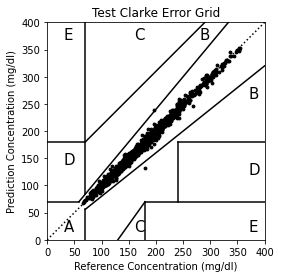

In [11]:
run_model(best3[2])

In [12]:
print(master_output)

{'ElasticNet': {'model': ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=1974, selection='cyclic', tol=0.0001, warm_start=False), 'model_name': 'ElasticNet', 'internal_cga_analysis': [3771, 17, 0, 3, 0], 'internal_rmse': 6.299894, 'internal_rmadex': 76.7682945269202, 'unseen_cga_analysis': [2783, 2, 0, 0, 0], 'unseen_rmse': 4.090810300594865, 'unseen_rmadex': 4.441852151455744}, 'BayesianRidge': {'model': BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False), 'model_name': 'BayesianRidge', 'internal_cga_analysis': [3775, 12, 1, 3, 0], 'internal_rmse': 6.323009391107487, 'internal_rmadex': 83.96785416518641, 'unseen_cga_analysis': [2783, 2, 0, 0, 0], 'unseen_rmse

In [13]:
pandas.DataFrame.from_dict(master_output, orient='index')

,model,model_name,internal_cga_analysis,internal_rmse,internal_rmadex,unseen_cga_analysis,unseen_rmse,unseen_rmadex
ElasticNet,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",ElasticNet,"[3771, 17, 0, 3, 0]",6.299894,76.768295,"[2783, 2, 0, 0, 0]",4.090810,4.441852
BayesianRidge,"BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, al...",BayesianRidge,"[3775, 12, 1, 3, 0]",6.323009,83.967854,"[2783, 2, 0, 0, 0]",4.055522,4.420274
Lasso,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso,"[3773, 15, 0, 3, 0]",6.289890,75.627784,"[2783, 2, 0, 0, 0]",4.130734,4.499319


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d560f233-0034-499f-bc4e-7ada8795cb9f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>